## Library

In [1]:
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 1000                                       # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = CURRENT_YEAR + 10_000                  # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "Anchors" notebook
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 23.4,
 5: 24.9,
 10: 25.6,
 20: 26.6,
 30: 27.4,
 40: 28.7,
 50: 30.3,
 60: 32.1,
 70: 34.0,
 80: 36.5,
 90: 40.0,
 95: 43.0,
 99: 49.10200000000005}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.7,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.6}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

delay

{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=4.37, lognorm_sd=1.93, norm_mean=1.39, norm_sd=0.42)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=12.12, lognorm_sd=9.64, norm_mean=2.25, norm_sd=0.7)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lo

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(1.5, 3.5),     # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 23),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1, 4.5, lclip=0.9),
             '2025_spend_doubling_time': sq.norm(0.94, 1.02, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

In [7]:
gdp_frac_samples = sq.sample(wildeford_max_gdp_frac, verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1083407.55it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031,
 50: 0.00039,
 60: 0.0005,
 70: 0.00069,
 80: 0.00106,
 90: 0.00208,
 95: 0.00386,
 99: 0.00955}

In [8]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
sq.get_log_percentiles(gdp_samples)

{1: '5.8e+09',
 5: '5.8e+09',
 10: '5.8e+09',
 20: '5.8e+09',
 30: '5.8e+09',
 40: '7.1e+09',
 50: '9.1e+09',
 60: '1.2e+10',
 70: '1.6e+10',
 80: '2.4e+10',
 90: '4.8e+10',
 95: '8.9e+10',
 99: '2.2e+11'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 33.4 log FLOP (~3 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~67 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~747 million). This doubles every 1.7 years to a max of 0.05394% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 33.4 log FLOP (3 decillion) - log $ 15.1 to buy TAI (1 quadrillion) vs. willingness to pay log $ 8.8 (704 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 33.3 log FLOP (2 decillion) - log $ 14.9 to buy TAI (721 trillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.3)

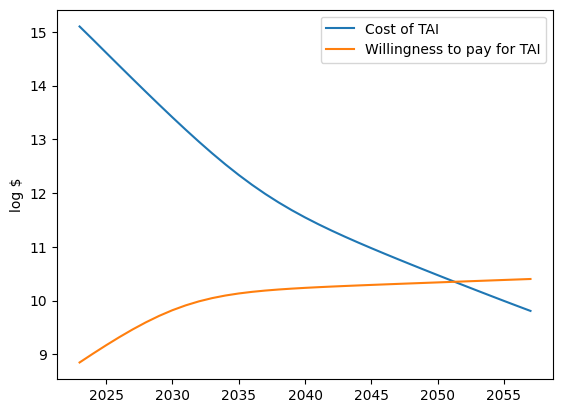

-
-
## SAMPLE RUN 2 ##
It takes 28.1 log FLOP (~13 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.3 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 2.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.8 to buy TAI (6 billion) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.5 to buy TAI (3 billion) vs. willingness to pay log $ 8.6 (377 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.2)
Ye

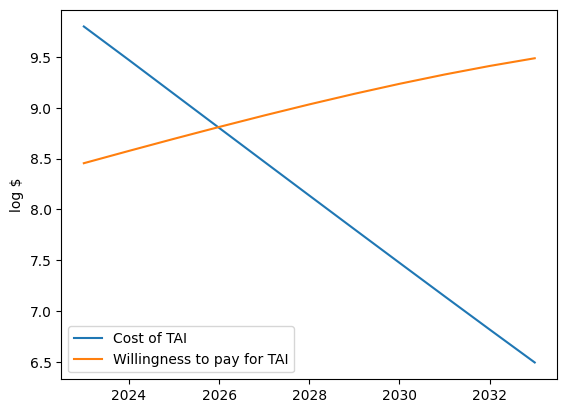

-
-
## SAMPLE RUN 3 ##
It takes 26.4 log FLOP (~251 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 9.4 log 2022$USD (~2 billion). This doubles every 3.3 years to a max of 0.21795% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 27.7 max log FLOP (5 octillion) available - TAI takes 26.4 log FLOP (251 septillion) - log $ 8.1 to buy TAI (126 million) vs. willingness to pay log $ 9.4 (2 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.7)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occu

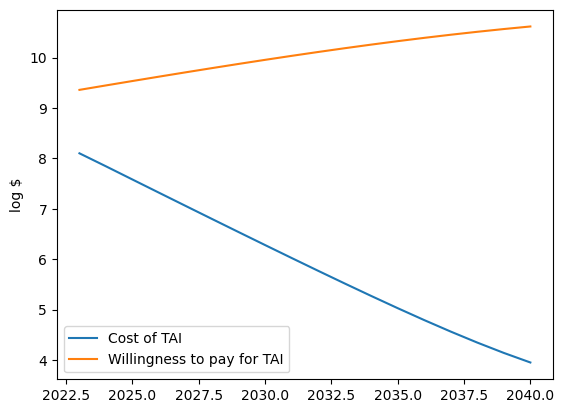

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.56it/s]


Shuffling data...
Waiting for other cores...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.70it/s]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2033',
 '10%: 2035',
 '15%: 2036',
 '20%: 2038',
 '25%: 2039',
 '35%: 2042',
 '50%: 2048',
 '60%: 2056',
 '75%: 2098',
 '80%: 2182',
 '90%: 2625',
 '95%: 2824']
(Mean: 2205)
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 10 years from now',
 '10%: 12 years from now',
 '15%: 13 years from now',
 '20%: 15 years from now',
 '25%: 16 years from now',
 '35%: 19 years from now',
 '50%: 25 years from now',
 '60%: 33 years from now',
 '75%: 75 years from now',
 '80%: 159 years from now',
 '90%: 602 years from now',
 '95%: 801 years from now']
(Mean: 182 years from now)
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.0%
2028-2029: 0.7%
2030-2034: 8.9%
2035-2039: 15.9%
2040-2049: 25.6%
2050-2059: 10.7%
2060-2069: 7.0%
2070-2079: 4.6%
2080-2089: 1.2%
2090-2099: 0.6%
2100-2109: 0.1%

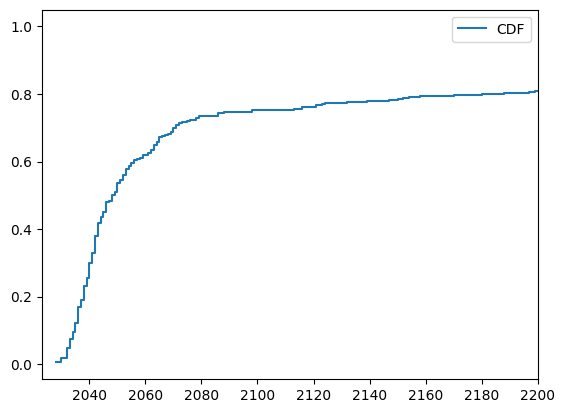

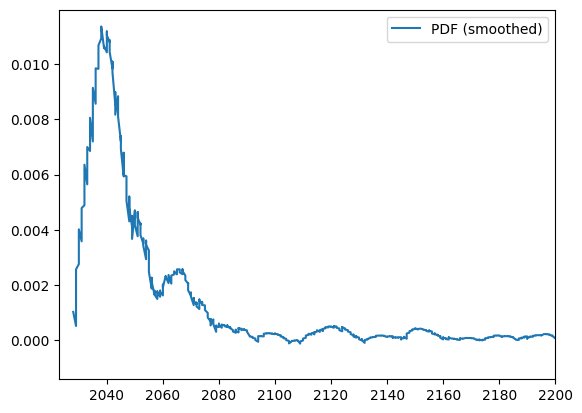

-
-
## TAI FLOP SIZE ##
{1: 23.0,
 5: 24.9,
 10: 25.6,
 20: 26.5,
 30: 27.5,
 40: 29.0,
 50: 30.7,
 60: 32.4,
 70: 34.4,
 80: 36.7,
 90: 39.8,
 95: 42.3,
 99: 47.5}
(Mean: 31.8)


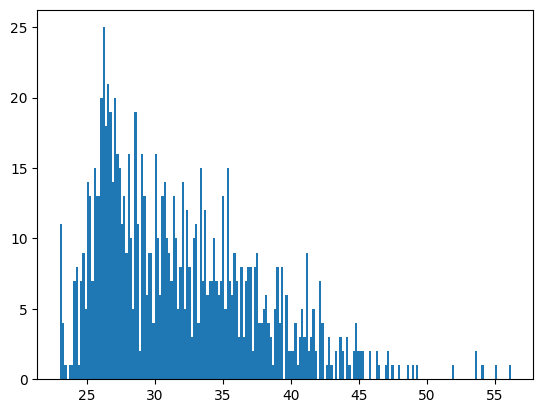

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 19.0,
 5: 14.5,
 10: 12.5,
 20: 10.2,
 30: 8.8,
 40: 7.7,
 50: 6.9,
 60: 6.0,
 70: 5.3,
 80: 4.6,
 90: 3.7,
 95: 3.2,
 99: 2.4}
(Mean: 7.6)


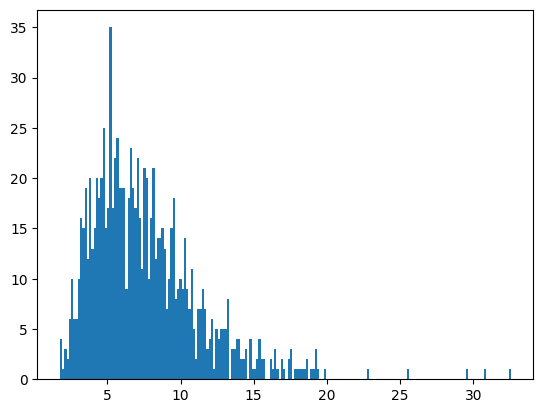

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.8,
 5: 3.5,
 10: 3.3,
 20: 3.0,
 30: 2.9,
 40: 2.7,
 50: 2.5,
 60: 2.4,
 70: 2.2,
 80: 2.0,
 90: 1.7,
 95: 1.5,
 99: 1.1}
(Mean: 2.5)


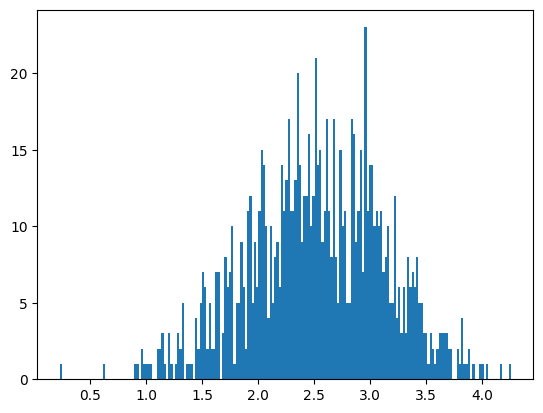

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.5,
 5: 20.9,
 10: 21.2,
 20: 21.4,
 30: 21.6,
 40: 21.8,
 50: 22.0,
 60: 22.1,
 70: 22.3,
 80: 22.5,
 90: 22.7,
 95: 22.9,
 99: 23.4}
(Mean: 22.0)


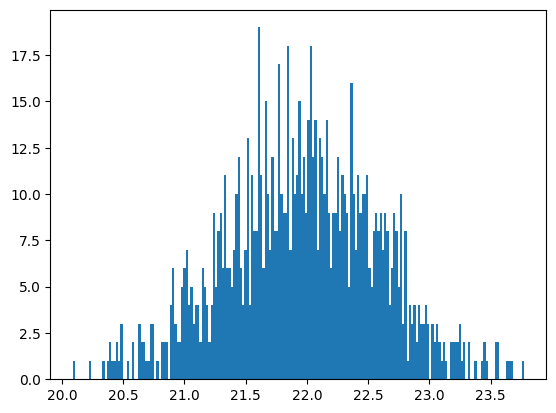

-
-
## INITIAL PAY ##
{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.5}
(Mean: 8.7)


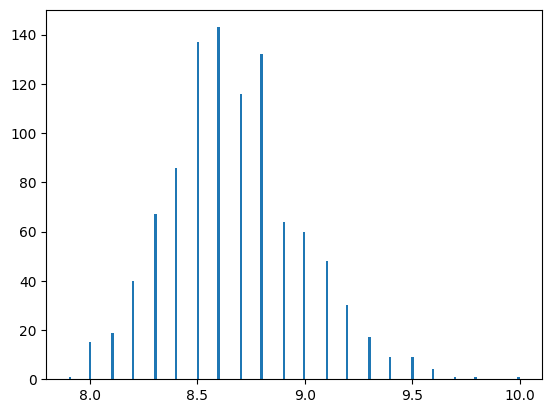

-
-
## GDP GROWTH ##
{1: 1.01,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.04,
 99: 1.04}
(Mean: 1.0)


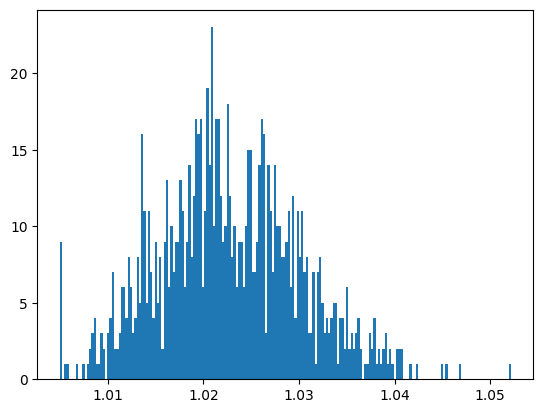

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00026,
 40: 0.00033,
 50: 0.00042,
 60: 0.00052,
 70: 0.00074,
 80: 0.00111,
 90: 0.00203,
 95: 0.00351,
 99: 0.00791}
(Mean: 0.0)


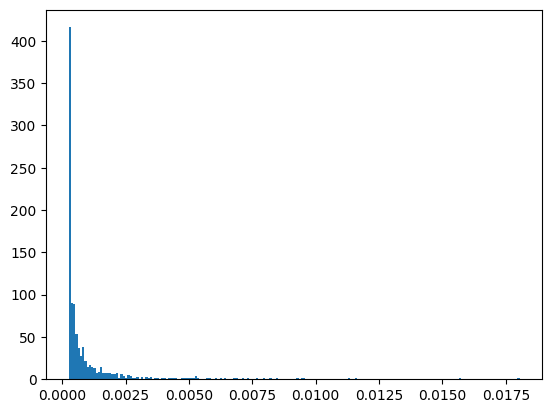

-
-
## SPEND DOUBLING TIME ##
{1: 5.2,
 5: 4.5,
 10: 4.1,
 20: 3.6,
 30: 3.3,
 40: 3.0,
 50: 2.7,
 60: 2.4,
 70: 2.1,
 80: 1.8,
 90: 1.3,
 95: 1.0,
 99: 0.9}
(Mean: 2.7)


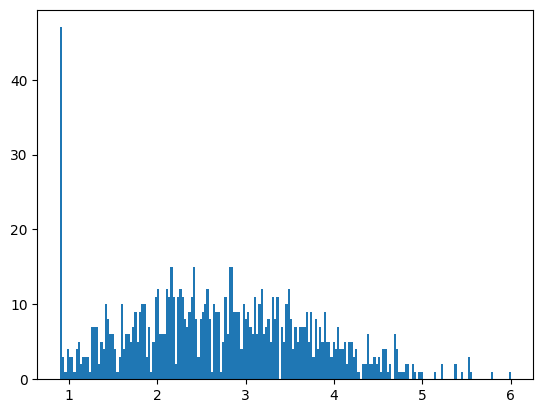

-
-
-
-
## GDP Over Time ##


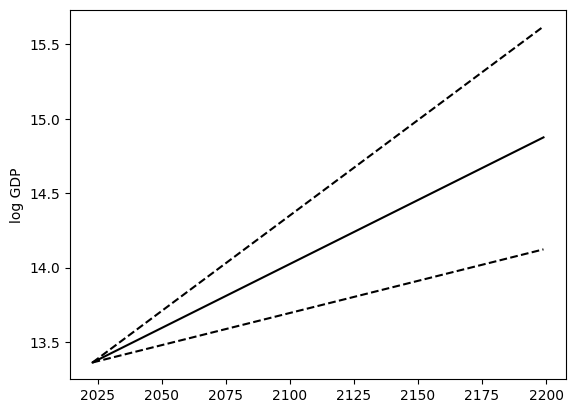

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

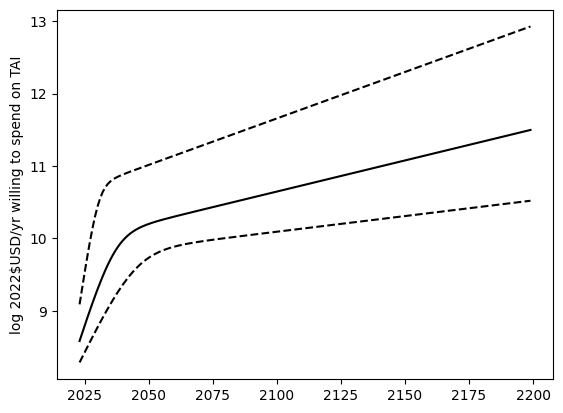

Year: 2023 - willingness log 2022$USD per year 8.6 (~382 million) 90% CI 8.3 (~193 million) - 9.1 (~1 billion)
Year: 2024 - willingness log 2022$USD per year 8.7 (~489 million) 90% CI 8.4 (~227 million) - 9.3 (~2 billion)
Year: 2025 - willingness log 2022$USD per year 8.8 (~624 million) 90% CI 8.4 (~267 million) - 9.5 (~3 billion)
Year: 2026 - willingness log 2022$USD per year 8.9 (~793 million) 90% CI 8.5 (~314 million) - 9.7 (~6 billion)
Year: 2027 - willingness log 2022$USD per year 9.0 (~1 billion) 90% CI 8.6 (~368 million) - 9.9 (~9 billion)
Year: 2028 - willingness log 2022$USD per year 9.1 (~1 billion) 90% CI 8.6 (~431 million) - 10.1 (~14 billion)
Year: 2029 - willingness log 2022$USD per year 9.2 (~2 billion) 90% CI 8.7 (~505 million) - 10.3 (~20 billion)
Year: 2030 - willingness log 2022$USD per year 9.3 (~2 billion) 90% CI 8.8 (~589 million) - 10.4 (~27 billion)
Year: 2031 - willingness log 2022$USD per year 9.4 (~2 billion) 90% CI 8.8 (~687 million) - 10.6 (~36 billion)
Yea

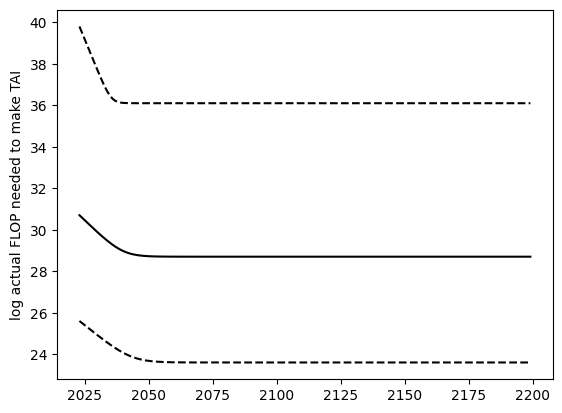

Year: 2023 - log FLOP needed for TAI 30.7 (~5 nonillion) 90% CI 25.6 (~40 septillion) - 39.8 (~6 million decillion)
Year: 2024 - log FLOP needed for TAI 30.6 (~4 nonillion) 90% CI 25.5 (~32 septillion) - 39.5 (~3 million decillion)
Year: 2025 - log FLOP needed for TAI 30.5 (~3 nonillion) 90% CI 25.4 (~25 septillion) - 39.2 (~2 million decillion)
Year: 2026 - log FLOP needed for TAI 30.3 (~2 nonillion) 90% CI 25.3 (~20 septillion) - 38.9 (~790 thousand decillion)
Year: 2027 - log FLOP needed for TAI 30.2 (~2 nonillion) 90% CI 25.2 (~16 septillion) - 38.6 (~396 thousand decillion)
Year: 2028 - log FLOP needed for TAI 30.1 (~1 nonillion) 90% CI 25.1 (~13 septillion) - 38.3 (~198 thousand decillion)
Year: 2029 - log FLOP needed for TAI 30.0 (~1000 octillion) 90% CI 25.0 (~10 septillion) - 38.0 (~100 thousand decillion)
Year: 2030 - log FLOP needed for TAI 29.9 (~770 octillion) 90% CI 24.9 (~8 septillion) - 37.7 (~51 thousand decillion)
Year: 2031 - log FLOP needed for TAI 29.8 (~596 octill

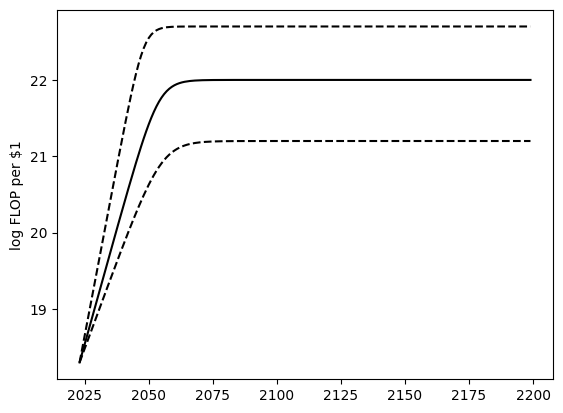

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~2 quintillion) - 18.5 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.7 (~5 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.6 (~4 quintillion) - 18.8 (~7 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.8 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 19.0 (~10 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~8 quintillion) 90% CI 18.8 (~6 quintillion) - 19.2 (~15 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~11 quintillion) 90% CI 18.8 (~7 quintillion) - 19.4 (~23 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~14 quintillion) 90% CI 18.9 (~9 quintillion) - 19.5 (~35 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.3 (~18 quintillion) 90% CI 19.0 (~11 quintillion) - 19.7 (~52 quint

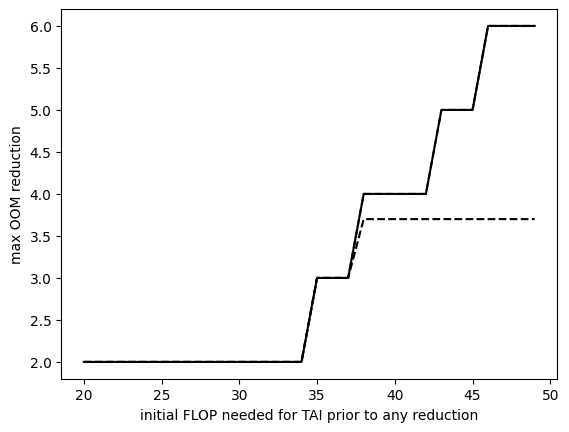

TAI log FLOP 20 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> 2.0 OOM reductions possible (

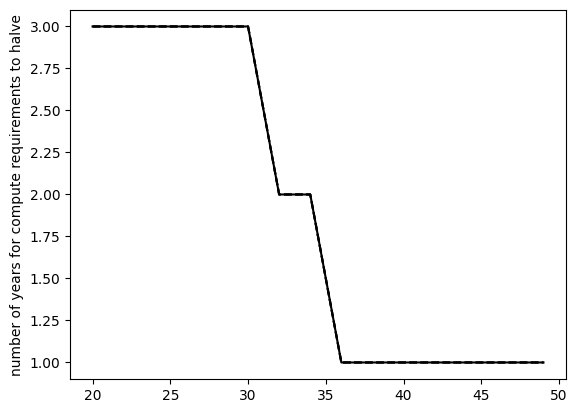

TAI log FLOP 20 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 21 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 22 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 23 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 24 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 25 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 26 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 27 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 28 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 29 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 30 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 31 -> algo doubling rate 2.5yrs (90% CI: 2.5 to 2.5)
TAI log FLOP 32 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FL

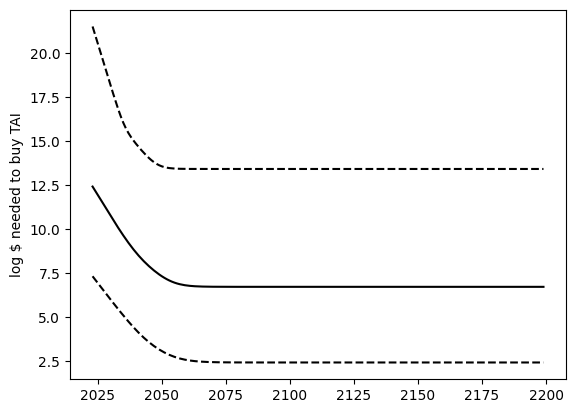

Year: 2023 - 12.4 log 2022$USD to buy TAI (~3 trillion) 90% CI 7.3 (~20 million) - 21.5 (~3 sextillion)
Year: 2024 - 12.2 log 2022$USD to buy TAI (~1 trillion) 90% CI 7.1 (~13 million) - 21.0 (~1 sextillion)
Year: 2025 - 11.9 log 2022$USD to buy TAI (~843 billion) 90% CI 6.9 (~8 million) - 20.5 (~350 quintillion)
Year: 2026 - 11.7 log 2022$USD to buy TAI (~487 billion) 90% CI 6.7 (~5 million) - 20.1 (~117 quintillion)
Year: 2027 - 11.4 log 2022$USD to buy TAI (~282 billion) 90% CI 6.5 (~4 million) - 19.6 (~39 quintillion)
Year: 2028 - 11.2 log 2022$USD to buy TAI (~163 billion) 90% CI 6.4 (~2 million) - 19.1 (~13 quintillion)
Year: 2029 - 11.0 log 2022$USD to buy TAI (~95 billion) 90% CI 6.2 (~1 million) - 18.6 (~4 quintillion)
Year: 2030 - 10.7 log 2022$USD to buy TAI (~55 billion) 90% CI 6.0 (~961 thousand) - 18.2 (~1 quintillion)
Year: 2031 - 10.5 log 2022$USD to buy TAI (~33 billion) 90% CI 5.8 (~627 thousand) - 17.7 (~498 quadrillion)
Year: 2032 - 10.3 log 2022$USD to buy TAI (~19

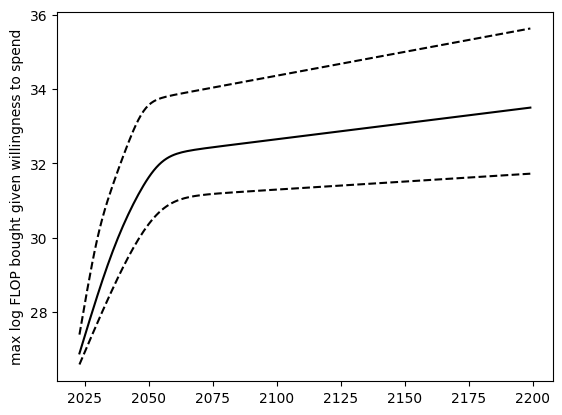

Year: 2023 - max log FLOP 26.9 (~763 septillion) 90% CI 26.6 (~384 septillion) - 27.4 (~2 octillion)
Year: 2024 - max log FLOP 27.1 (~1 octillion) 90% CI 26.7 (~558 septillion) - 27.8 (~6 octillion)
Year: 2025 - max log FLOP 27.3 (~2 octillion) 90% CI 26.9 (~810 septillion) - 28.2 (~15 octillion)
Year: 2026 - max log FLOP 27.6 (~4 octillion) 90% CI 27.1 (~1 octillion) - 28.6 (~38 octillion)
Year: 2027 - max log FLOP 27.8 (~6 octillion) 90% CI 27.2 (~2 octillion) - 29.0 (~90 octillion)
Year: 2028 - max log FLOP 28.0 (~10 octillion) 90% CI 27.4 (~2 octillion) - 29.3 (~208 octillion)
Year: 2029 - max log FLOP 28.2 (~17 octillion) 90% CI 27.5 (~4 octillion) - 29.7 (~457 octillion)
Year: 2030 - max log FLOP 28.4 (~27 octillion) 90% CI 27.7 (~5 octillion) - 30.0 (~950 octillion)
Year: 2031 - max log FLOP 28.6 (~45 octillion) 90% CI 27.9 (~7 octillion) - 30.3 (~2 nonillion)
Year: 2032 - max log FLOP 28.9 (~72 octillion) 90% CI 28.0 (~10 octillion) - 30.5 (~3 nonillion)
Year: 2033 - max log FL

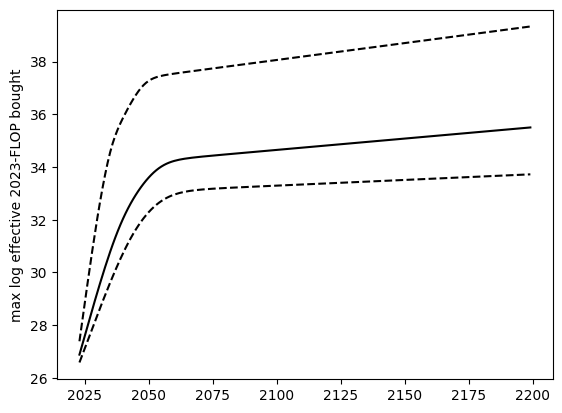

Year: 2023 - max log effective 2023-FLOP 26.9 (~763 septillion) 90% CI 26.6 (~384 septillion) - 27.4 (~2 octillion)
Year: 2024 - max log effective 2023-FLOP 27.2 (~2 octillion) 90% CI 26.8 (~694 septillion) - 28.1 (~12 octillion)
Year: 2025 - max log effective 2023-FLOP 27.6 (~4 octillion) 90% CI 27.1 (~1 octillion) - 28.8 (~61 octillion)
Year: 2026 - max log effective 2023-FLOP 27.9 (~8 octillion) 90% CI 27.4 (~2 octillion) - 29.5 (~301 octillion)
Year: 2027 - max log effective 2023-FLOP 28.3 (~18 octillion) 90% CI 27.6 (~4 octillion) - 30.2 (~1 nonillion)
Year: 2028 - max log effective 2023-FLOP 28.6 (~39 octillion) 90% CI 27.9 (~8 octillion) - 30.8 (~7 nonillion)
Year: 2029 - max log effective 2023-FLOP 28.9 (~84 octillion) 90% CI 28.1 (~14 octillion) - 31.5 (~29 nonillion)
Year: 2030 - max log effective 2023-FLOP 29.3 (~178 octillion) 90% CI 28.4 (~24 octillion) - 32.1 (~119 nonillion)
Year: 2031 - max log effective 2023-FLOP 29.6 (~375 octillion) 90% CI 28.6 (~44 octillion) - 32.7

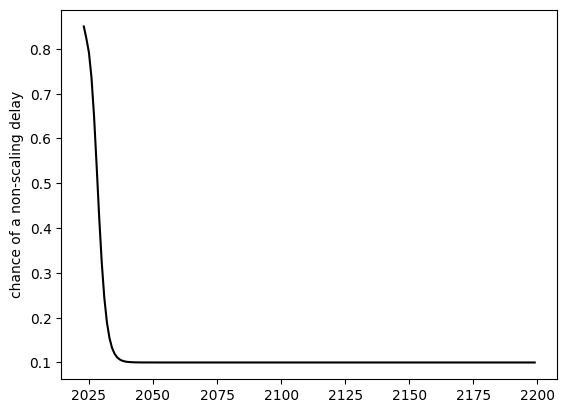

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 82%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 79%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 74%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 65%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 54%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 42%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 32%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2033

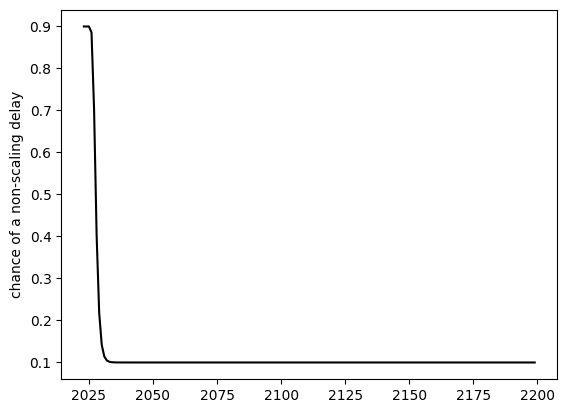

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

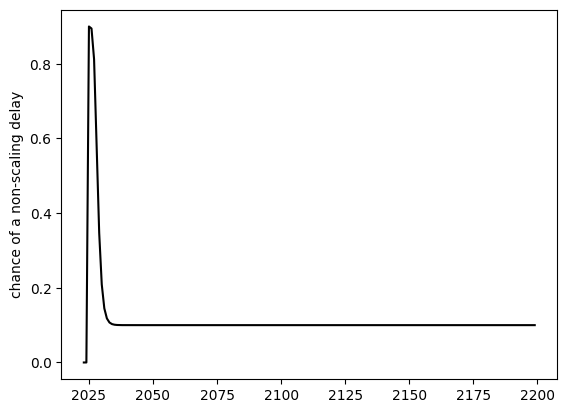

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 81%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 58%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 35%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2033 -

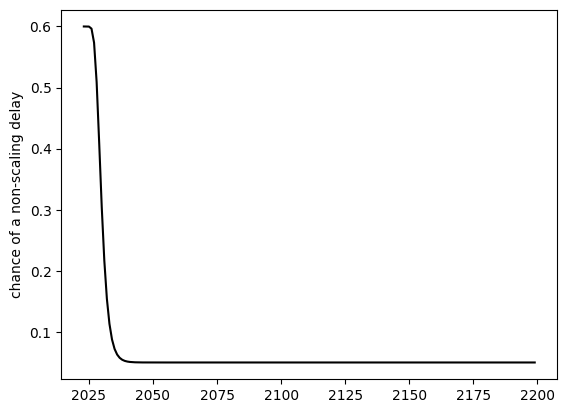

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 57%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 51%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 41%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2033

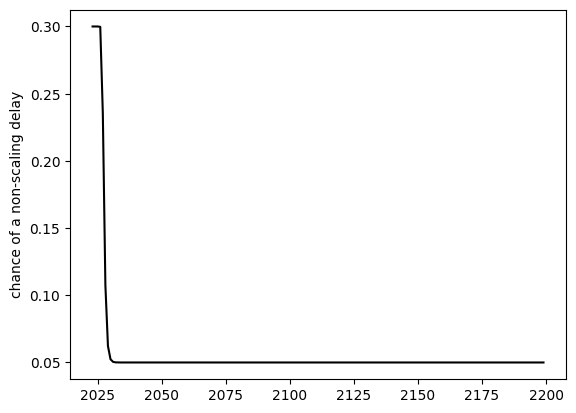

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - c

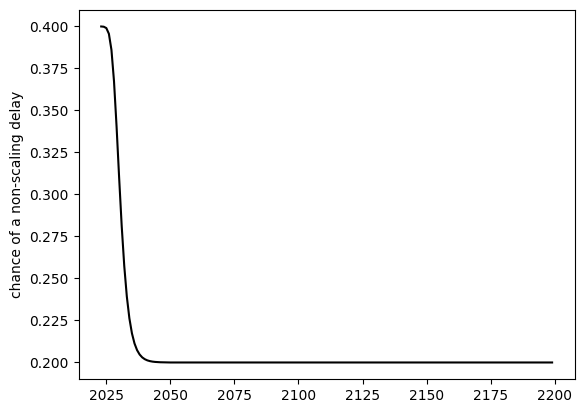

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 34%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 31%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2033

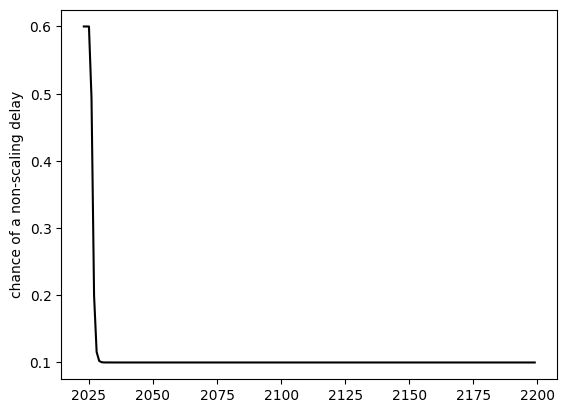

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 49%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

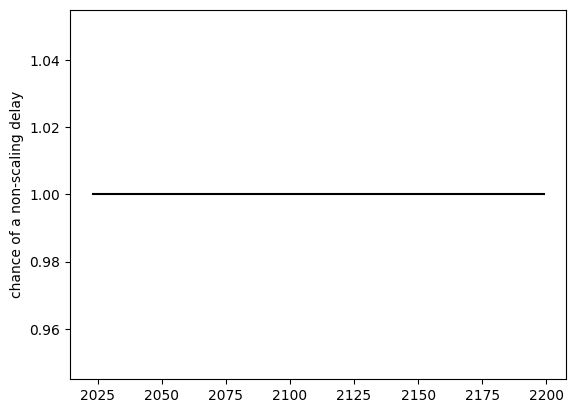

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%


/Users/peterhurford/.virtualenvs/dev/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/peterhurford/.virtualenvs/dev/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

In [9]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


In [ ]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)